In [1]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline

/Users/tmulc/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Generate Gaussian data

Want a distribution data that is normal

$y \sim N(\mu,\sigma^2)$

In [2]:
num_points = 100000
mu = 0
sigma = 1.0 

y = np.random.normal(mu,sigma,num_points)
Y = np.expand_dims(y,1)
#y1 = np.random.normal(mu,sigma,num_points)


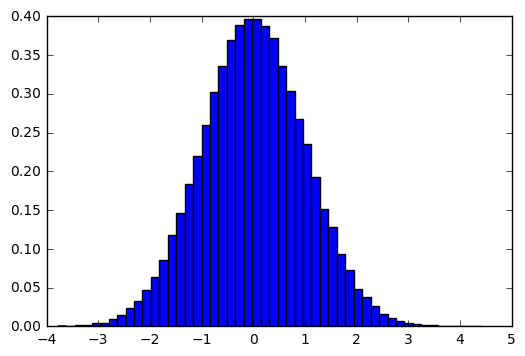

In [3]:
#plt.hist2d(y,y1,bins=100)
plt.hist(y,bins=50,normed=True)
plt.show()

# Latent space

In [4]:
z_size=10
def Z(batch_size,z_size=10):
    return np.random.uniform(-1.,1.,size=[batch_size,z_size])

# Miscellanous

In [5]:
batch_size = 500

# discriminator

In [6]:
g = tf.Graph()
num_nodes_d=1000
with g.as_default():
    data_input = tf.placeholder(tf.float32,shape=[batch_size,1])
    
    W_d1 = tf.Variable(tf.truncated_normal([1,num_nodes_d]))
    b_d1 = tf.Variable(tf.zeros([num_nodes_d]))
    W_d2 = tf.Variable(tf.truncated_normal([num_nodes_d,1]))
    b_d2 = tf.Variable(tf.zeros([1]))
    
    d_vars = [W_d1,b_d1,W_d2,b_d2]
    def D(x,var_l):
        W1,b1 = var_l[0],var_l[1]
        W2,b2 = var_l[2],var_l[3]
        logit=tf.matmul(tf.sigmoid(tf.matmul(x,W1)+b1),W2)+b2
        return logit

# generator

In [7]:
num_nodes_g=1000
with g.as_default():
    z_input = tf.placeholder(tf.float32,shape=[batch_size,z_size])
    
    W_g1 = tf.Variable(tf.truncated_normal([z_size,num_nodes_g]))
    b_g1 = tf.Variable(tf.zeros([num_nodes_g]))
    W_g2 = tf.Variable(tf.truncated_normal([num_nodes_g,1]))
    b_g2 = tf.Variable(tf.zeros([1]))
    
    g_vars =[W_g1,b_g1,W_g2,b_g2]
    
    def G(z,var_l):
        W1,b1 = var_l[0],var_l[1]
        W2,b2 = var_l[2],var_l[3]
        
        l1 = tf.sigmoid(tf.matmul(z,W1)+b1)
        g = tf.matmul(l1,W2)+b2
        
        return g

# Train

In [8]:
with g.as_default():
    D_data = D(data_input,d_vars)
    G_z = G(z_input,g_vars)
    D_g = D(G_z,d_vars)
    
    loss_d =-tf.reduce_mean(tf.log(tf.sigmoid(D_data)) +tf.log(1- tf.sigmoid(D_g)))
    loss_g = tf.reduce_mean(tf.log(1- tf.sigmoid(D_g)))
    
    opt = tf.train.AdamOptimizer(learning_rate=.00002,beta1=.5)
    
    train_d = opt.minimize(loss_d,var_list=d_vars)
    train_g = opt.minimize(loss_g,var_list=g_vars)

# Other ops

In [9]:
with g.as_default():
    init = tf.initialize_all_variables()

# Train Session

In [10]:
sess = tf.Session(graph = g)
sess.run(init)

In [11]:
epoch_size = Y.shape[0]/batch_size

In [12]:
lossesd,lossesg = [],[]

In [13]:
num_epochs = 50
for _ in tqdm(range(num_epochs)):
    for s in range(epoch_size):
        fd = {data_input:Y[s*batch_size:s*batch_size+batch_size,:],z_input:Z(batch_size,z_size)}
        ld,_=sess.run([loss_d,train_d],feed_dict=fd)
        lg,_=sess.run([loss_g,train_g],feed_dict=fd)
        lossesd.append(ld),lossesg.append(lg)

100%|██████████| 50/50 [01:56<00:00,  2.16s/it]


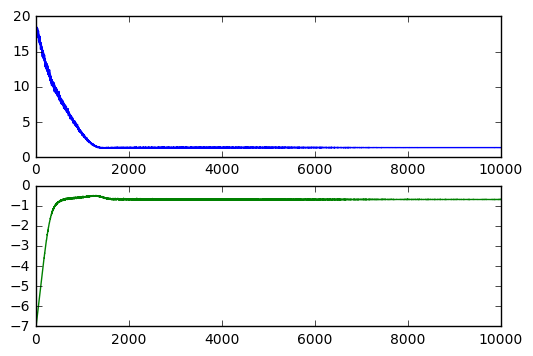

In [14]:
plt.subplot(211)
plt.plot(lossesd,color='blue')
plt.subplot(212)
plt.plot(lossesg,color='green')

# Visualize

In [15]:
G_test=sess.run(G_z,feed_dict=fd)

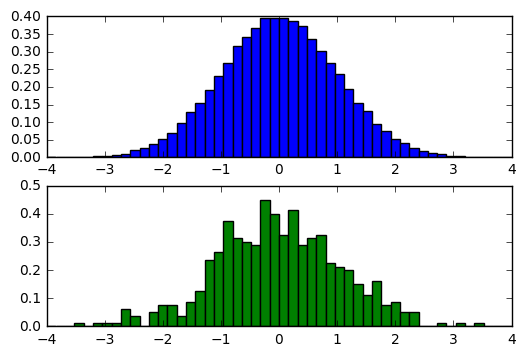

In [16]:
#fig = plt.subplot(21)
plt.subplot(211)
plt.hist(y,bins=50,normed=True,color='blue',range=[-4,4])
plt.subplot(212)
plt.hist(G_test[:,0],bins=50,normed=True,range=[-4,4],color='green')
#plt.xlim(-6,-8)
plt.show()

In [90]:
#plt.plot(X[:,0],X[:,1],'b^',G_test[:,0],G_test[:,1],'ro')
# plt.savefig('images/img')